In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

import networkx as nx
from matplotlib import colormaps
from matplotlib.colors import Normalize

import geopandas as gpd
import contextily as ctx

In [20]:
passagers = pd.read_csv("../data_chall_alstom/passagers.csv")
print(passagers.info())
plan_metro = pd.read_csv("../data_chall_alstom/plan_du_métro.csv")
print(plan_metro.info())
position_gps = pd.read_csv("../data_chall_alstom/position_gps_des_stations_de_métro.csv")
print(position_gps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  385 non-null    object
 1   GPS      385 non-null    object
d

### Mis en forme des jeu de données

In [21]:
plan_metro_ligne = plan_metro[plan_metro["de Station"]!=plan_metro["vers Station"]]
position_gps['lat'], position_gps['lng'] = zip(*position_gps['GPS'].apply(lambda x: x.split(',')))


In [22]:
stations=[]
"""
ligne_nb = list(range(1,15))
ligne_nb=[chr(x) for x in ligne_nb]
ligne_nb.append("3bis")
ligne_nb.append("7bis")
"""
ligne_nb=["1","2","3","3bis","4","5","6","7","8","9","10","11","12","13","14","7bis"]

for ligne in ligne_nb :
    liste_coord=[]
    df_lignei=plan_metro_ligne[plan_metro_ligne["de Ligne"]==ligne]
    station = df_lignei["de Station"].unique()

    for st in station:
        if not(position_gps[position_gps['Station']==st].empty):
            liste_coord.append([float(position_gps[position_gps['Station']==st].iat[0,3]), float(position_gps[position_gps['Station']==st].iat[0,2])])

        
    
    if ligne!="8":
        pop=liste_coord.pop()
        if ligne=="1" :
            liste_coord.insert(0,pop)
    stations.append({'coordinates' : liste_coord, 'type': 'LineString'})

plan_ligne = pd.DataFrame()
plan_ligne["ligne"] = ligne_nb
plan_ligne["station"] = stations

### Representation graphique du reseau

In [23]:
ligne_1=plan_ligne.loc[7]
idf_map = folium.Map(location=[48.868, 2.365], zoom_start=12, tiles='Cartodb dark_matter')


for segment in plan_ligne["station"]:
    gjson = folium.features.GeoJson(segment,
                                    style_function = lambda x: {'color': '#ED6852',
                                                                'weight': 1.5})
    idf_map.add_child(gjson)


for i, v in position_gps.iterrows():
    folium.CircleMarker(location=[v['lat'], v['lng']],
                        radius=1.2,
                        color='#FFFFF0',
                        fill_color='#FFFFFF',
                        fill=True).add_to(idf_map)
idf_map

### Creation de la matrice

In [24]:
import math

#On calcule la distance avec la formule de Haversine
def calcul_distance(station1, station2):
    coord_station1 = position_gps.loc[position_gps["Station"] == station1, "GPS"].iloc[0]
    coord_station2 = position_gps.loc[position_gps["Station"] == station2, "GPS"].iloc[0]
    lat1 , lon1 = map(float, coord_station1.split(", "))
    lat2 , lon2 = map(float, coord_station2.split(", "))
    # Rayon de la Terre en kilomètres
    R = 6371.0
    
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Différences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Distance
    distance = R * c
    return distance

def calcul_temps(station1,station2,vitesse):
    return round(calcul_distance(station1,station2)/vitesse*3600)

In [25]:
def creation_matrice(plan_metro, position):
    plan_metro_grouped = plan_metro.groupby("de Station")
    passagers_dict = passagers.set_index(["de", "vers"])["nombre"].to_dict()

    # Liste unique des stations
    liste_station = position["Station"].unique()

    # Initialisation d'un dictionnaire pour construire le graph
    graph_dict = {station: [] for station in liste_station}

    # Construction optimisée du graph
    for depuis in liste_station:
        lien = plan_metro_grouped.get_group(depuis)["vers Station"].unique() if depuis in plan_metro_grouped.groups else []

        # Créer une liste pour chaque station de départ
        for vers in liste_station:
            noeud = {
                "ligne": [],
                "passager": passagers_dict.get((depuis, vers), 0) if depuis != vers else 0
            }

            if vers in lien:
                noeud["ligne"] = list(plan_metro[
                    (plan_metro["de Station"] == depuis) & 
                    (plan_metro["vers Station"] == vers)
                ]["de Ligne"].unique())

            graph_dict[depuis].append(noeud)

    # Conversion en DataFrame
    graph = pd.DataFrame(graph_dict, index=liste_station)
    return graph

In [26]:
df=creation_matrice(plan_metro, position_gps)

In [27]:
df

,Boucicaut,Bourse,Bir-Hakeim,Argentine,Daumesnil,Église d'Auteuil,George V,Franklin D. Roosevelt,Europe,Jacques Bonsergent,...,Malakoff - Plateau de Vanves,Tolbiac,Victor Hugo,Poissonnière,Avron,Église de Pantin,Château d'Eau,Guy Môquet,Monceau,Rome
Boucicaut,"{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 2}",...,"{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 5}"
Bourse,"{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 4}",...,"{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 6}"
Bir-Hakeim,"{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 3}",...,"{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 8}"
Argentine,"{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 0}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 1}",...,"{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 4}","{'ligne': [], 'passager': 4}"
Daumesnil,"{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 5}","{'ligne': ['6', '8'], 'passager': 0}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 3}",...,"{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 7}","{'ligne': [], 'passager': 2}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 4}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Église de Pantin,"{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 8}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 1}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 3}","{'ligne': [], 'passager': 1}",...,"{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 5}","{'ligne': [], 'passager': 6}","{'ligne': [], 'passager': 9}","{'ligne': [], 'passager': 4}",

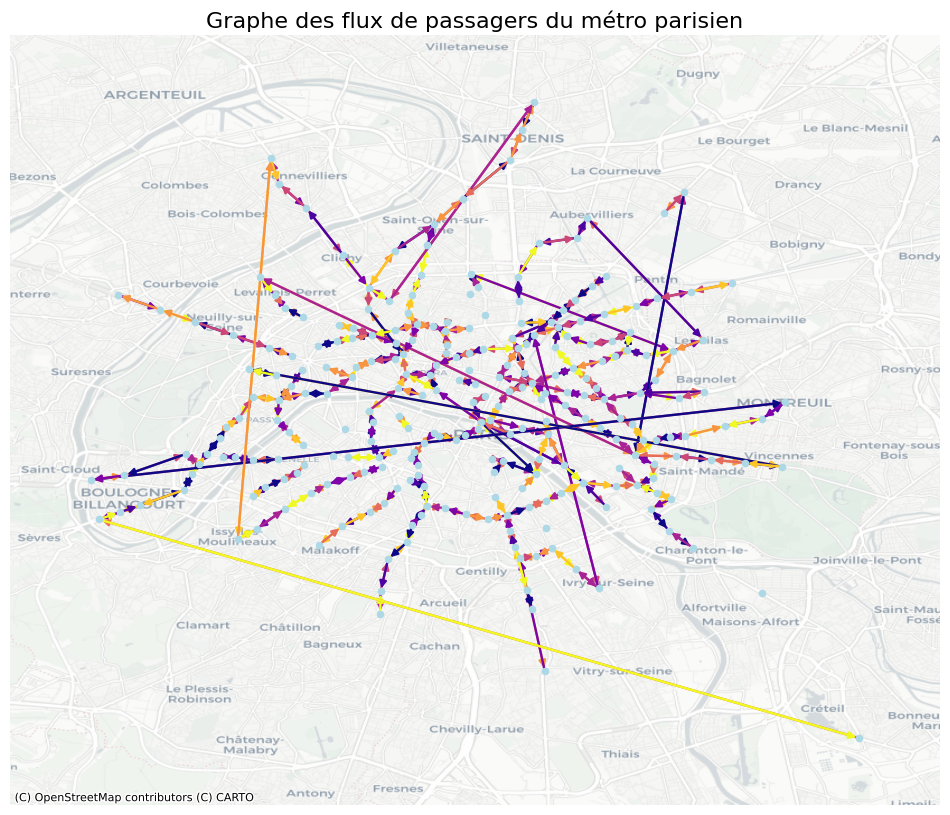

In [28]:
G = nx.DiGraph()

for depuis in df.index:  # Lignes
    for vers in df.columns:  # Colonnes
        info = df.loc[depuis, vers]
        if (info["ligne"]) and (depuis != vers):  # Si la liste 'ligne' n'est pas vide
            # Ajout d'une arête avec les attributs 'ligne' et 'passager'
            G.add_edge(depuis, vers, ligne=info["ligne"], passagers=info["passager"])

# Visualisation (optionnel)
for i, node in position_gps.iterrows():
    G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"]))) 



# Récupérer les positions des nœuds pour NetworkX
pos=nx.get_node_attributes(G, "pos")

# Convertir les positions en GeoDataFrame pour reprojection
gdf_nodes = gpd.GeoDataFrame(
    {"name": list(pos.keys())},
    geometry=gpd.points_from_xy([position[0] for position in pos.values()], [position[1] for position in pos.values()]),
    crs="EPSG:4326",  # WGS84 (latitude/longitude)
)

# Reprojeter en EPSG:3857 (Web Mercator)
gdf_nodes = gdf_nodes.to_crs(epsg=3857)
positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

# Calcul des largeurs des arêtes (en fonction des passagers)
passager_values = [data["passagers"] for _, _, data in G.edges(data=True)]
norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
cmap = colormaps["plasma"]
edge_colors = [cmap(norm(data["passagers"])) for _, _, data in G.edges(data=True)]

# Préparer la figure
fig, ax = plt.subplots(figsize=(12, 10))

# Ajouter les nœuds et les arêtes au graphe
nx.draw(
    G,
    pos=positions_3857,  # Utiliser les coordonnées reprojetées
    with_labels=False,
    node_color="lightblue",
    edge_color=edge_colors,
    node_size=20,
    font_size=10,
    width=1.7,
    ax=ax,
)

# Ajouter un fond de carte
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Afficher la carte
plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
plt.show()


In [29]:
# Liste des stations à exclure
stations_exclues = [
    "Charles de Gaulle - Étoile", "Champs-Élysées - Clemenceau", "Palais-Royal - Musée du Louvre",
    "Reuilly - Diderot", "Barbès - Rochechouart", "Havre - Caumartin", "Réaumur - Sébastopol",
    "Marcadet - Poissonniers", "Montparnasse - Bienvenüe", "Bobigny - Pablo Picasso",
    "La Motte-Picquet - Grenelle", "Richelieu - Drouot", "Bonne-Nouvelle", "Sèvres - Babylone",
    "Châtillon - Montrouge", "Louvre - Rivoli", "Pereire", "Quatre-Septembre", "Richard-Lenoir",
    "Bréguet - Sabin", "Campo-Formio", "Sèvres - Lecourbe", "Aubervilliers - Pantin - Quatre Chemins",
    "Pont-Neuf", "Sully - Morland", "Censier - Daubenton", "Villejuif - Paul Vaillant-Couturier",
    "Pré-Saint-Gervais", "La Tour-Maubourg", "Saint-Sébastien - Froissart", "Ledru-Rollin",
    "Faidherbe - Chaligny", "École vétérinaire de Maisons-Alfort", "Maisons-Alfort - Les Juilliottes",
    "Créteil - L'Échat", "Créteil - Université", "Créteil - Préfecture", "Chardon-Lagache",
    "Avenue Émile-Zola", "Cluny - La Sorbonne", "Maubert - Mutualité", "Lamarck - Caulaincourt",
    "Trinité - d'Estienne d'Orves", "Assemblée nationale", "Malakoff - Rue Étienne-Dolet","Château Rouge",
    "Bibliothèque François-Mitterrand","Cambronne","École Militaire","Grands Boulevards","Maisons-Alfort - Stade","Jules Joffrin","Olympiades"
]

# Filtrer les données pour exclure ces stations
passagers_filtre = passagers[
    ~passagers['de'].isin(stations_exclues) & ~passagers['vers'].isin(stations_exclues)
]

# Afficher les données filtrées
print(passagers_filtre)


                       de                          vers  nombre
0              La Défense       Esplanade de La Défense       7
1              La Défense               Pont de Neuilly       5
2              La Défense                   Les Sablons       6
3              La Défense                 Porte Maillot       6
4              La Défense                     Argentine       5
...                   ...                           ...     ...
93321  Cour Saint-Émilion                     Plaisance       7
93322  Cour Saint-Émilion               Porte de Vanves       8
93323  Cour Saint-Émilion  Malakoff - Plateau de Vanves       3
93326  Cour Saint-Émilion                    Saint-Ouen       6
93327  Cour Saint-Émilion                 Pont Cardinet       2

[64262 rows x 3 columns]


In [ ]:
from collections import defaultdict

def calculer_flux_passagers(graphe, donnees):
    """
    Calcule le flux de passagers à travers un graphe en fonction des données de trajet.
    Chaque flux directionnel est traité séparément sans addition dans l'autre sens.
    
    :param graphe: Graph NetworkX représentant le réseau de transport.
    :param donnees: Liste de tuples (gare_depart, gare_arrivee, nombre_passagers).
    :return: Deux dictionnaires contenant les flux par nœud et par arête.
    """
    # Initialisation des flux
    flux_par_noeud = defaultdict(int)
    flux_par_arete = defaultdict(int)

    # Calcul des trajets pour chaque donnée
    for gare_depart, gare_arrivee, nombre_passagers in donnees:
        try:
            # Trouver le chemin le plus court
            chemin = nx.shortest_path(graphe, source=gare_depart, target=gare_arrivee)
            
            # Ajouter les passagers à chaque nœud et arête du chemin
            for i in range(len(chemin)):
                # Ajouter au flux du nœud
                flux_par_noeud[chemin[i]] += nombre_passagers
                if i < len(chemin) - 1:
                    # Ajouter au flux de l'arête (en gardant la direction distincte)
                    u, v = chemin[i], chemin[i + 1]
                    flux_par_arete[(u, v)] += nombre_passagers
        except nx.NetworkXNoPath:
            print(f"Pas de chemin entre {gare_depart} et {gare_arrivee}.")

    return flux_par_noeud, flux_par_arete


# Exemple d'utilisation
if __name__ == "__main__":
   
   
    donnees = list(passagers_filtre[['de', 'vers', 'nombre']].itertuples(index=False, name=None))

    # Calcul des flux
    flux_noeuds, flux_aretes = calculer_flux_passagers(G, donnees)

    # Afficher les résultats
    #print("Flux par nœud :")
    #for noeud, flux in flux_noeuds.items():
    #    print(f"{noeud} : {flux}")
#
    #print("\nFlux par arête :")
    #for arete, flux in flux_aretes.items():
    #    print(f"{arete} : {flux}")

# Convertir les résultats en DataFrame
flux_noeuds_df = pd.DataFrame(list(flux_noeuds.items()), columns=['Noeud', 'Flux'])
flux_aretes_df = pd.DataFrame(list(flux_aretes.items()), columns=['Arete', 'Flux'])

# Ajouter des colonnes pour les nœuds de départ et d'arrivée dans le DataFrame des arêtes
flux_aretes_df[['Noeud_depart', 'Noeud_arrivee']] = pd.DataFrame(flux_aretes_df['Arete'].tolist(), index=flux_aretes_df.index)
flux_aretes_df = flux_aretes_df.drop(columns=['Arete'])

# Enregistrer les DataFrames dans des fichiers CSV
flux_noeuds_df.to_csv("flux_par_noeud.csv", index=False, encoding="utf-8")
flux_aretes_df.to_csv("flux_par_arete.csv", index=False, encoding="utf-8")

In [40]:
def graph_flux(flux_df, position):

    G = nx.DiGraph()

    for i, edge in flux_df.iterrows():
        G.add_edge(edge["Noeud_depart"], edge["Noeud_arrivee"], passager=edge["Flux"])

    # Visualisation (optionnel)
    for i, node in position.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"]))) 



    # Récupérer les positions des nœuds pour NetworkX
    pos=nx.get_node_attributes(G, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([p[0] for p in pos.values()], [p[1] for p in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passager"] for _, _, data in G.edges(data=True)]
    norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
    cmap = colormaps["plasma"]
    edge_colors = [cmap(norm(data["passager"])) for _, _, data in G.edges(data=True)]

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        connectionstyle="arc3,rad=-0.1",
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()


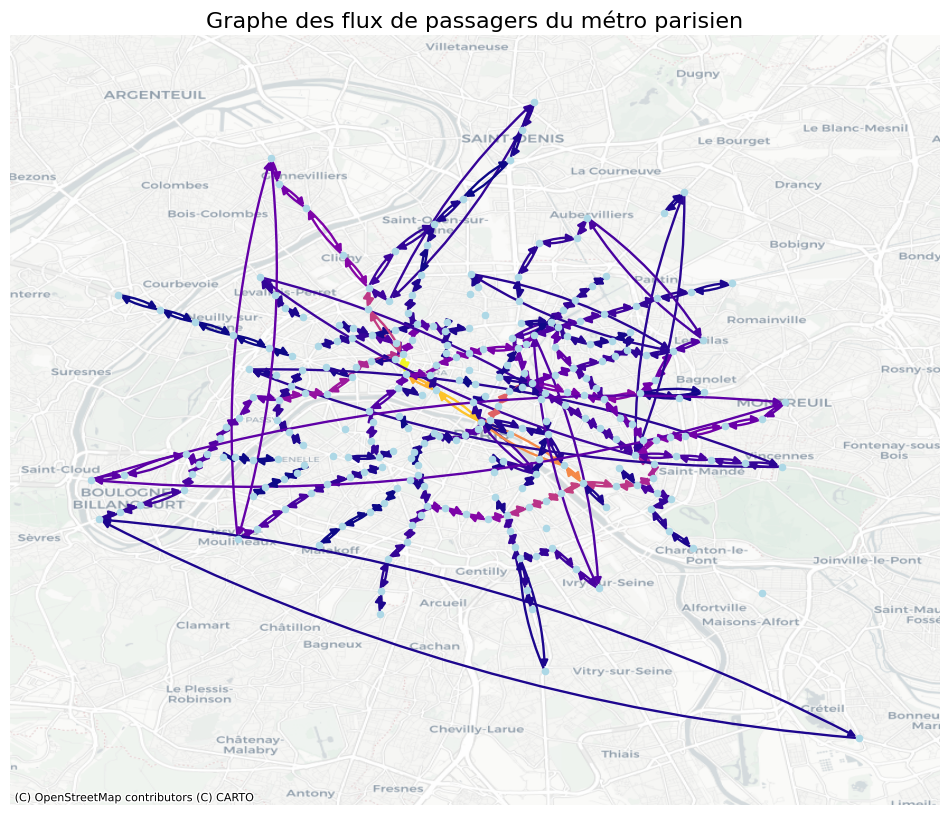

In [41]:
graph_flux(flux_aretes_df, position_gps)

In [ ]:
def graph_noeud(flux_df, position):

    G = nx.DiGraph()

    for i, edge in flux_df.iterrows():
        G.add_edge(edge["Noeud_depart"], edge["Noeud_arrivee"], passager=edge["Flux"])

    # Visualisation (optionnel)
    for i, node in position.iterrows():
        G.add_node(node["Station"], pos=(float(node["lng"]), float(node["lat"]))) 



    # Récupérer les positions des nœuds pour NetworkX
    pos=nx.get_node_attributes(G, "pos")

    # Convertir les positions en GeoDataFrame pour reprojection
    gdf_nodes = gpd.GeoDataFrame(
        {"name": list(pos.keys())},
        geometry=gpd.points_from_xy([p[0] for p in pos.values()], [p[1] for p in pos.values()]),
        crs="EPSG:4326",  # WGS84 (latitude/longitude)
    )

    # Reprojeter en EPSG:3857 (Web Mercator)
    gdf_nodes = gdf_nodes.to_crs(epsg=3857)
    positions_3857 = {row["name"]: (row.geometry.x, row.geometry.y) for _, row in gdf_nodes.iterrows()}

    # Calcul des largeurs des arêtes (en fonction des passagers)
    passager_values = [data["passager"] for _, _, data in G.edges(data=True)]
    norm = Normalize(vmin=min(passager_values), vmax=max(passager_values), clip=True)
    cmap = colormaps["plasma"]
    edge_colors = [cmap(norm(data["passager"])) for _, _, data in G.edges(data=True)]

    # Préparer la figure
    fig, ax = plt.subplots(figsize=(12, 10))

    # Ajouter les nœuds et les arêtes au graphe
    nx.draw(
        G,
        pos=positions_3857,  # Utiliser les coordonnées reprojetées
        connectionstyle="arc3,rad=-0.1",
        with_labels=False,
        node_color="lightblue",
        edge_color=edge_colors,
        node_size=20,
        font_size=10,
        width=1.7,
        ax=ax,
    )

    # Ajouter un fond de carte
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Afficher la carte
    plt.title("Graphe des flux de passagers du métro parisien", fontsize=16)
    plt.show()